# DATA AUGMENTATION WITH A SAE WITH CONVOLUTIONAL LAYERS

In [1]:
import numpy as np 
import tensorflow as tf
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.python.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import tensorflow as tf    

In [3]:
####### lOAD DATA ##########

### COPY FROM BUCKET TO LOCAL STORAGE ####
# !gsutil -m cp gs://dataham/Dataset/MEL/train_mel.npy ./dataset
# !gsutil -m cp gs://dataham/Dataset/MEL/test_mel.npy ./dataset
# !gsutil -m cp gs://dataham/Dataset/NV/train_nv.npy ./dataset
# !gsutil -m cp gs://dataham/Dataset/NV/test_nv.npy ./dataset


#### LOAD DATA FROM LOCAL STORAGE ### 

###### MEL: class 1 ######
x_mel_train, x_mel_test = np.load("./data/train_mel.npy"), np.load("./data/test_mel.npy")
y_mel_train, y_mel_test = np.ones((x_mel_train.shape[0], )), np.ones((x_mel_test.shape[0], ))


###### NV: class 0 ######
x_nv_train, x_nv_test = np.load("./data/train_nv.npy"), np.load("./data/test_nv.npy")
y_nv_train, y_nv_test = np.zeros((x_nv_train.shape[0], )), np.zeros((x_nv_test.shape[0], ))

In [4]:
x_mel_train.shape, x_mel_test.shape

((887, 128, 128, 3), (226, 128, 128, 3))

In [5]:
x_nv_train.shape , x_nv_test.shape

((5365, 128, 128, 3), (1340, 128, 128, 3))

In [6]:
####### PARAMS FOR THE SAE: CLASS MEL ########

model_params_mel = { "x_train": x_mel_train,
                    "x_val": x_mel_test,
                    "img_rows": 128, 
                    "img_cols": 128,
                    "img_chns" :  3,
                    "latent_dim" : 3,
                    "intermediate_dim" : 128,
                    "epsilon_std" : 1.0,
                    "epochs" : 100,
                    'filters' : 32,
                    "kernel_size" : 3,
                    "batch_size" : 16,
                    "name_model":"SAE_MEL"
                    }

In [7]:
####### PARAMS FOR THE SAE: CLASS NV ########

model_params_nv = { "x_train": x_nv_train,
                    "x_val": x_nv_test,
                    "img_rows": 128, 
                    "img_cols": 128,
                    "img_chns" :  3,
                    "latent_dim" : 3,
                    "intermediate_dim" : 128,
                    "epsilon_std" : 1.0,
                    "epochs" : 50,
                    'filters' : 8,
                    "kernel_size" : 2,
                    "batch_size" : 16,
                    "name_model":"SAE_NV"
                    }

In [8]:
"""

The following model is fit on HAM10000 datase with only observations of class MEL

"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.callbacks import ModelCheckpoint

img_rows, img_cols, img_chns = 128, 128, 3


def evaluate_SAE( x_train = x_mel_train, 
                 x_val = x_mel_test,
                 img_rows = 128, 
                img_cols  = 128,
                img_chns =  3,
                latent_dim = 2,
                intermediate_dim = 128,
                epsilon_std = 1.0,
                epochs = 50,
                filters = 32,
                kernel_size = 3,
                batch_size = 32,
                name_model = 'SAE'):


    K.clear_session()

    # tensorflow uses channels_last
    # theano uses channels_first
    if K.image_data_format() == 'channels_first':
        original_img_size = (img_chns, img_rows, img_cols)
    else:
        original_img_size = (img_rows, img_cols, img_chns)


    # encoder architecture
    x = Input(shape=original_img_size)

    #x = Input(shape=(32,32,3))
    conv_1 = Conv2D(img_chns,
                    kernel_size=(2, 2),
                    padding='same', activation='relu')(x)
#     conv_2 = Conv2D(filters,
#                     kernel_size=(2, 2),
#                     padding='same', activation='relu',
#                     strides=(2, 2))(conv_1)
    conv_3 = Conv2D(filters,
                    kernel_size=kernel_size, ## kernel_size = 3 meaning (3,3) filter size 
                    padding='same', activation='relu',
                    strides=1)(conv_1)
    conv_4 = Conv2D(filters,
                    kernel_size=kernel_size,
                    padding='same', activation='relu',
                    strides=1)(conv_3)
    flat = Flatten()(conv_4)
    hidden = Dense(intermediate_dim, activation='relu')(flat)

    # mean and variance for latent variables
    z_mean = Dense(latent_dim)(hidden)
    z_log_var = Dense(latent_dim)(hidden) ## log of variance so take the log afterwards 

    # sampling layer
    # def sampling(args):
    #     z_mean, z_log_var = args
    #     epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
    #                               mean=0., stddev=epsilon_std)
    #     #epsilon = K.random_normal(shape=(2, 2),
    #         #                     mean=0., stddev=epsilon_std)
    #     return z_mean + K.exp(z_log_var) * epsilon

    
    # reparametrization trick to find z out of z_mean and z_log_var
    # z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    # z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])




    # decoder architecture
    decoder_hid = Dense(intermediate_dim, activation='relu') # FC of size 128
    decoder_upsample = Dense(int(filters * img_rows / 2 * img_cols / 2), activation='relu') # Dense(32*16*16)

    # For second dense layer 
    if K.image_data_format() == 'channels_first':
        output_shape = (batch_size, filters, int(img_rows / 2), int(img_cols / 2))
    else:
        output_shape = (batch_size, int(img_rows / 2), int(img_cols / 2), filters)


    decoder_reshape = Reshape(output_shape[1:]) ## 16*16*32
    decoder_deconv_1 = Conv2DTranspose(filters,
                                       kernel_size = 2,
                                       padding = 'same',
                                       strides = 1,
                                       activation='relu')
    
#     decoder_deconv_2 = Conv2DTranspose(filters,
#                                        kernel_size=kernel_size,
#                                        padding='same',
#                                        strides=1,
#                                        activation='relu')
    decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                              kernel_size=(3, 3),
                                              strides=(2, 2),
                                              padding='valid',
                                              activation='relu')
    decoder_mean_squash = Conv2D(img_chns,
                                 kernel_size=2,
                                 padding='valid',
                                 activation='sigmoid')


    # Linking the layers
    hid_decoded = decoder_hid(z_mean)

    up_decoded = decoder_upsample(hid_decoded)
    reshape_decoded = decoder_reshape(up_decoded)

    deconv_1_decoded = decoder_deconv_1(reshape_decoded)
    #     deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
    x_decoded_relu = decoder_deconv_3_upsamp(deconv_1_decoded)
    #     x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
    x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)



    # Custom loss layer
    class CustomVariationalLayer(Layer):
        def __init__(self, **kwargs):
            self.is_placeholder = True
            super(CustomVariationalLayer, self).__init__(**kwargs)

        def sae_loss(self, x, x_decoded_mean_squash):
            x = K.flatten(x)
            x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
            xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
            kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
            return K.mean(xent_loss + kl_loss)

        def call(self, inputs):
            x = inputs[0]
            x_decoded_mean_squash = inputs[1]
            loss = self.sae_loss(x, x_decoded_mean_squash)
            self.add_loss(loss, inputs=inputs)
            return x


    y = CustomVariationalLayer()([x, x_decoded_mean_squash])

    ######### ENTIRE MODEL #########
    sae = Model(x, y)
    #################################
    sae.compile(optimizer='rmsprop', loss=None)
   
    ######## CALLBACKS: we will only keep the model that best fit the data based on validation loss #########
    
    model_best_path= "weights{}.hdf5".format(name_model)
    callbacks = [
                
                ModelCheckpoint(model_best_path, monitor='val_loss', save_best_only=True, verbose=0)
               
                ]
    
    ####################################
    
    ############ TRAINING: fit training data, no label necessary ##########
    sae.fit(x_train, 
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data = (x_val, None),
            callbacks=callbacks,
            verbose = 1          
            )
    ###################################################
    
        
    # encoder from learned model
    encoder = Model(x, z_mean)

    # generator / decoder from learned model
    decoder_input = Input( shape=(latent_dim,) )
    _hid_decoded = decoder_hid(decoder_input)
    _up_decoded = decoder_upsample(_hid_decoded)
    _reshape_decoded = decoder_reshape(_up_decoded)
    _deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
#     _deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
    _x_decoded_relu = decoder_deconv_3_upsamp(_deconv_1_decoded)
    _x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
    generator = Model(decoder_input, _x_decoded_mean_squash, name = 'generator --decoder_SAE')   
    
    
    
    return sae, generator     

Using TensorFlow backend.


## FITTING CLASS MEL AND GENERATING DATA FROM SAME UNDERLYING DISTRIBUTION

In [9]:
model_SAE_mel, generator = evaluate_SAE(**model_params_mel)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 887 samples, validate on 226 samples
Epoch 1/100
887/887 [==============================] - 20s 23ms/step - loss: 10967.6201 - val_loss: 10657.2410
Epoch 2/100
887/887 [==============================] - 9s 11ms/step - loss: 10659.4671 - val_loss: 11234.0101
Epoch 3/100
887/887 [==============================] - 9s 11ms/step - loss: 10598.5831 - val_loss: 10635.3961
Epoch 4/100
887/887 [==============================] - 9s 11ms/step - loss: 10480.1222 - val_loss: 10410.1884
Epoch 5/100
887/887 [==============================] - 9s 11ms/step - loss: 10413.8865 - val_loss: 10352.8020
Epoch 6/100
887/887 [==============================] - 9s 11ms/step - loss: 10379.5745 - val_loss: 10308.1509
Epoch 7/100
887/887 [==============================] - 9s 11ms/step - loss: 10356.2893 - val_loss: 10308.1257
Epoch 8/100
887/887 [==============================] - 9s 10ms/

887/887 [==============================] - 9s 11ms/step - loss: 10127.1373 - val_loss: 10327.1698
Epoch 70/100
887/887 [==============================] - 9s 11ms/step - loss: 10126.2387 - val_loss: 10311.3553
Epoch 71/100
887/887 [==============================] - 9s 11ms/step - loss: 10122.9687 - val_loss: 10317.6991
Epoch 72/100
887/887 [==============================] - 9s 11ms/step - loss: 10123.6512 - val_loss: 10345.1313
Epoch 73/100
887/887 [==============================] - 9s 11ms/step - loss: 10122.1913 - val_loss: 10330.3244
Epoch 74/100
887/887 [==============================] - 9s 10ms/step - loss: 10120.6296 - val_loss: 10307.5417
Epoch 75/100
887/887 [==============================] - 9s 11ms/step - loss: 10119.1320 - val_loss: 10312.3314
Epoch 76/100
887/887 [==============================] - 9s 11ms/step - loss: 10118.0097 - val_loss: 10334.2906
Epoch 77/100
887/887 [==============================] - 9s 11ms/step - loss: 10120.0299 - val_loss: 10334.3482
Epoch 78/100
8

In [11]:
filename = "./generated/images_SAE_mel.npy"


def generate_images(generator = generator, latent_dim = 3, filename = filename, verbose = False, nb_obs_power3 = 17):
    # display a 2D manifold of the digits
    n = nb_obs_power3  # figure with 17*17*17 digits
    digit_size = 128*128*3


    # linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
    # to produce values of the latent variables z, since the prior of the latent space is Gaussian
    grid_x = 1.5*norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = 1.5*norm.ppf(np.linspace(0.05, 0.95, n))
    grid_z = 1.5*norm.ppf(np.linspace(0.05, 0.95, n))

    #grid_x = norm.ppf(np.linspace(-10.0, 10.0, n))
    #grid_y = norm.ppf(np.linspace(-10.0, 10.0, n))
    total_aug_mel = np.empty((n**3, 128,128,3))
    iteration = 0 
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            for k,zi in enumerate(grid_z):
                # xi = input()
                # yi = input()
                # zi = input()
                z_sample = np.array([[xi, yi,zi]])
                # print z_sample
                x_decoded = generator.predict(z_sample) ## shape (1,128,128,3)
                digit = x_decoded[0]
                total_aug_mel[iteration] = digit
                iteration += 1 
                if iteration % 1000 == 0:
                    print("Nice! {} steps done already! :)".format(iteration))
                if verbose: 
                    plt.figure(figsize=(10, 10))
                    plt.imshow(digit, cmap='Greys_r')
                    plt.show()
    
    # save file
    np.save(filename, total_aug_mel )
    return total_aug_mel


In [12]:
sample_aug_mel = generate_images(nb_obs_power3=9)

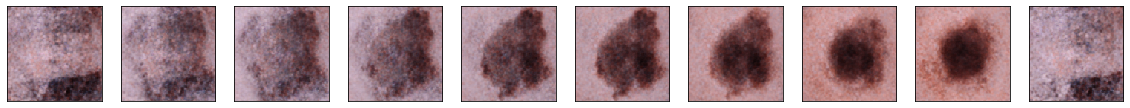

In [13]:
def plot_images(images, n):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        image = images[i].reshape(128, 128, 3)
        plt.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
plot_images(sample_aug_mel, 10)

In [14]:
total_aug_mel = generate_images()

Nice! 1000 steps done already! :)
Nice! 2000 steps done already! :)
Nice! 3000 steps done already! :)
Nice! 4000 steps done already! :)
